# Compound Treats Disease Edge Prediction

This notebook is designed to take the next step moving from predicted sentences to edge predictions. After training the discriminator model, each sentences contains a confidence score for the likelihood of mentioning a relationship. Multiple relationships contain multiple sentences, which makes establishing an edge unintuitive. Is taking the max score appropiate for determining existence of an edge? Does taking the mean of each relationship make more sense? The answer towards these questions are shown below.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
total_candidates_df = (
    pd
    .read_table("../dataset_statistics/data/all_dg_candidates_map.tsv.xz")
    .sort_values("candidate_id")
)
total_candidates_df.head(2)

,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
74951,189,AGXT,DOID:2531,hematologic cancer,NaN,0,2668,1,0.88258,1,0.0,3.0,1.0,553297,A review of the literature since the use of ch...,38,21421
1655246,3630,INS,DOID:1793,pancreatic cancer,NaN,0,1763,1,0.19694,0,0.0,1.0,1.0,635063,The presence of insulin antibodies did not imp...,13,21422


In [3]:
sentence_prediction_df = (
    pd
    .read_table("results/all_predicted_sentences.tsv")
    .sort_values("candidate_id")
)
sentence_prediction_df.head(2)

,candidate_id,model_prediction
0,21421,0.513273
1,21422,0.566447


In [4]:
# DataFrame that combines likelihood scores with each candidate sentence
total_candidates_pred_df = (
    total_candidates_df[[
    "doid_id", "doid_name", 
    "entrez_gene_id", "gene_symbol", 
    "text", "hetionet",
    "candidate_id", "split"
    ]]
    .merge(sentence_prediction_df, on="candidate_id")
)
#total_candidates_pred_df.to_csv(
#    "results/combined_predicted_dag_sentences.tsv.xz", 
#    sep="\t", index=False, compression="xz"
#)
total_candidates_pred_df.head(2)

,doid_id,doid_name,entrez_gene_id,gene_symbol,text,hetionet,candidate_id,split,model_prediction
0,DOID:2531,hematologic cancer,189,AGXT,A review of the literature since the use of ch...,0,21421,1,0.513273
1,DOID:1793,pancreatic cancer,3630,INS,The presence of insulin antibodies did not imp...,0,21422,0,0.566447


In [5]:
# DataFrame that groups disease and gene mentions together and takes
# the max, median and mean of each group
grouped_candidates_pred_df=(
    total_candidates_pred_df
    .query("split==2")
    .groupby(["doid_id", "entrez_gene_id"], as_index=False)
    .agg({
        "model_prediction": ['max', 'mean', 'median'], 
        'hetionet': 'max',
        "gene_symbol": 'first',
        "doid_name": 'first'
    })
)
grouped_candidates_pred_df.head(2)

doid_id entrez_gene_id model_prediction                     hetionet  \
                                            max      mean    median      max   
0  DOID:0050156              2         0.477118  0.474932  0.474932        0   
1  DOID:0050156             16         0.652162  0.574500  0.576386        0   

  gene_symbol                      doid_name  
        first                          first  
0         A2M  idiopathic pulmonary fibrosis  
1        AARS  idiopathic pulmonary fibrosis

In [6]:
grouped_candidates_pred_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'gene_symbol', 'doid_name'] else col[0] 
    for col in grouped_candidates_pred_df.columns.values
]
grouped_candidates_pred_df.head(2)

,doid_id,entrez_gene_id,model_prediction_max,model_prediction_mean,model_prediction_median,hetionet,gene_symbol,doid_name
0,DOID:0050156,2,0.477118,0.474932,0.474932,0,A2M,idiopathic pulmonary fibrosis
1,DOID:0050156,16,0.652162,0.574500,0.576386,0,AARS,idiopathic pulmonary fibrosis


In [7]:
grouped_candidates_pred_df.hetionet.value_counts()

0    13460
1      943
Name: hetionet, dtype: int64

In [8]:
performance_map = {}

In [9]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.model_prediction_max,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.model_prediction_max,
)

performance_map['max'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [10]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.model_prediction_mean,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.model_prediction_mean,
)

performance_map['mean'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [11]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.model_prediction_median,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_df.hetionet, 
    grouped_candidates_pred_df.model_prediction_median,
)

performance_map['median'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

# Hetionet Reconstruction 

How well does the sentence marginals reconstruct hetionet?

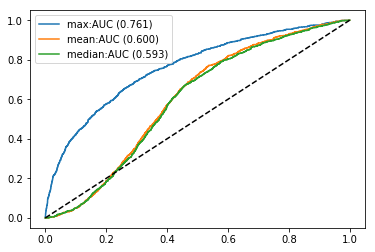

In [12]:
for key in performance_map:
    plt.plot(
        performance_map[key]['false_pos'], 
        performance_map[key]['true_pos'], 
        label=f"{key}:AUC ({auc(performance_map[key]['false_pos'], performance_map[key]['true_pos']):.3f})"
    )
plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.legend()
plt.show()

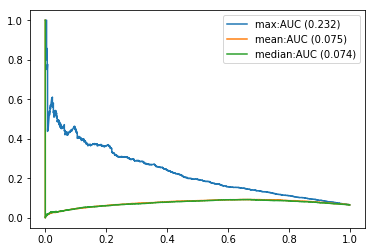

In [13]:
for key in performance_map:
    plt.plot(
        performance_map[key]['recall'], 
        performance_map[key]['precision'], 
        label=f"{key}:AUC ({auc(performance_map[key]['recall'], performance_map[key]['precision']):.3f})"
    )

plt.legend()
plt.show()

# Optimial Cutoff Using PR-CURVE 

In [14]:
threshold_df = (
    pd.DataFrame(
        list(
            zip(
                performance_map['max']['precision'], 
                performance_map['max']['recall'], 
                performance_map['max']['pr_threshold']
            )
        ),
        columns=["precision", "recall", "pr_threshold"]
    )
    .sort_values("precision", ascending=False)
)
threshold_df.head(2)

,precision,recall,pr_threshold
14352,1.0,0.001060,0.925382
14351,1.0,0.002121,0.912428


In [15]:
#precision_thresholds = pd.np.linspace(0,1,num=5)
precision_thresholds = threshold_df.round(2).drop_duplicates("precision").precision.values

# Add the lowest precision rather than
# Keep it zero
precision_thresholds = (
    pd.np.where(
        precision_thresholds==0, 
        threshold_df.precision.min(), 
        precision_thresholds
    )
)

performance_records = []
for precision_cutoff in precision_thresholds:

    cutoff = (
        threshold_df
        .query("precision>=@precision_cutoff")
        .pr_threshold
        .min()
    )
    
    values_added = (
        grouped_candidates_pred_df
        .query("model_prediction_max >= @cutoff")
        .hetionet
        .value_counts()
    )
    
    series_keys = list(values_added.keys())
    for key in series_keys:
        performance_records.append(
           {  
               "edges": values_added[key], 
               "in_hetionet": "Existing" if key == 1 else "Novel", 
               "precision": precision_cutoff,
               "sen_cutoff": cutoff
           }
        )
   
    
edges_added_df = (
    pd
    .DataFrame
    .from_records(performance_records)
)
edges_added_df.head(10)

,edges,in_hetionet,precision,sen_cutoff
0,4,Existing,1.00,0.890759
1,4,Existing,0.86,0.890759
2,6,Existing,0.83,0.882406
3,1,Novel,0.83,0.882406
4,6,Existing,0.80,0.882406
5,1,Novel,0.80,0.882406
6,6,Existing,0.78,0.882406
7,1,Novel,0.78,0.882406
8,7,Existing,0.75,0.878007
9,2,Novel,0.75,0.878007


[None]

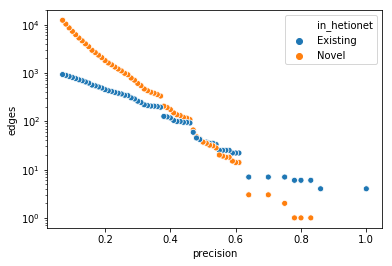

In [16]:
ax = sns.scatterplot(x="precision", y="edges", hue="in_hetionet", data=edges_added_df)
ax.set(yscale="log")

In [17]:
edges_added_df.to_csv("results/precision_dag_edges_added.tsv", index=False, sep="\t")

# Optimial Cutoff using ROC Curve

In [18]:
# https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = pd.np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 
roc_optimal = Find_Optimal_Cutoff(grouped_candidates_pred_df.hetionet.values, grouped_candidates_pred_df.model_prediction_max)[0]
roc_optimal

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/ipykernel/__main__.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


0.6733811

In [19]:
(
    grouped_candidates_pred_df
    .query("model_prediction_max > @roc_optimal")
    .sort_values("hetionet")
    .hetionet.value_counts()
)

0    4110
1     655
Name: hetionet, dtype: int64

In [20]:
(
    grouped_candidates_pred_df
    .query("model_prediction_max > @roc_optimal")
    .sort_values(["hetionet", "model_prediction_max"], ascending=[True, False])
)

,doid_id,entrez_gene_id,model_prediction_max,model_prediction_mean,model_prediction_median,hetionet,gene_symbol,doid_name
1302,DOID:10652,7436,0.885586,0.603065,0.605009,0,VLDLR,Alzheimer's disease
4951,DOID:1612,5967,0.878466,0.543552,0.523666,0,REG1A,breast cancer
14030,DOID:9744,9370,0.877440,0.573045,0.557339,0,ADIPOQ,type 1 diabetes mellitus
4838,DOID:1612,3643,0.877109,0.604476,0.606413,0,INSR,breast cancer
1187,DOID:10652,2026,0.876868,0.532546,0.499462,0,ENO2,Alzheimer's disease
12567,DOID:7148,367,0.876734,0.584182,0.602246,0,AR,rheumatoid arthritis
3847,DOID:1324,5716,0.875562,0.800104,0.854747,0,PSMD10,lung cancer
5153,DOID:1612,29126,0.875432,0.592087,0.570595,0,CD274,breast cancer
10625,DOID:3393,1493,0.875293,0.642736,0.666297,0,CTLA4,coronary artery disease
518,DOID:10283,5915,0.874068,0.500906,0.494964,0,RARB,prostate cancer
